# Lotka-Volterra models: deterministic continuous time models

## [Scientific Computing with Python](http://scicompy.yoavram.com)
## Yoav Ram

In [1]:
from functools import partial

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

import scipy
from scipy.integrate import solve_bvp, solve_ivp, odeint
from ipywidgets import interact

[Lotka-Volterra models](https://en.wikipedia.org/wiki/Lotka–Volterra_equations) are models of species interactions, which can consist of competition, cooperation, or other types of interactions.

We will focus now on predation.

# Predator-prey model

The predator-prey model is summarized by these equations:

$$
\frac{dx}{dt} = b x - h x y \\
\frac{dy}{dt} = \epsilon h x y - d y
$$

where the parameters are:
- $x$ is the density of the prey (rabbits)
- $y$ is the density of the predator (foxes)
- $b$ is the prey birth rate
- $d$ is the predator death rate
- $h$ is the rate at which, when predator and prey meet, predation occurs
- $\epsilon$ is the rate at which prey density is converted to predator density when predation occurs

![lynx and hare](https://globalchange.umich.edu/globalchange1/current/lectures/predation/lynx_hare.jpg)

# Dynamics

To implement the model we first write the ODE as a function:

In [2]:
def dxydt(t, xy, b, h, ϵ, d):
    x, y = xy
    dx = b * x - h * x * y
    dy = ϵ * h * x * y - d * y
    return np.array([dx, dy])

Now let's integrate it - first let's implement an integration on our own:

In [4]:
b = 1
h = 0.005
ϵ = 0.8
d = 0.6

steps = 100000
xy = np.empty((2, steps))
xy[:,0] = 50, 100
dt = 0.001

for t_ in range(1, steps):
    xy[:,t_] = xy[:, t_-1] + dxydt(t_, xy[:, t_-1], b, h, ϵ, d) * dt
x = xy[0, :]
y = xy[1, :]
t = np.arange(0, dt * steps, dt)

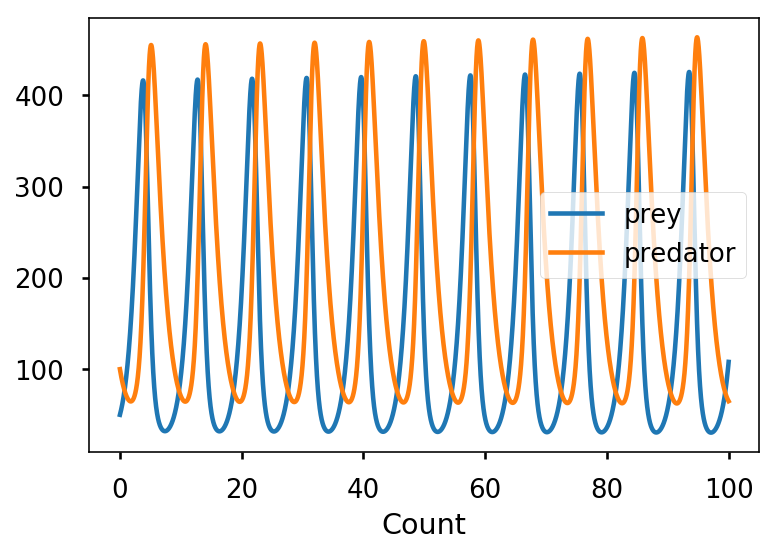

In [5]:
plt.plot(t, x, label='prey')
plt.plot(t, y, label='predator')
plt.xlabel('Time')
plt.xlabel('Count')
plt.legend();

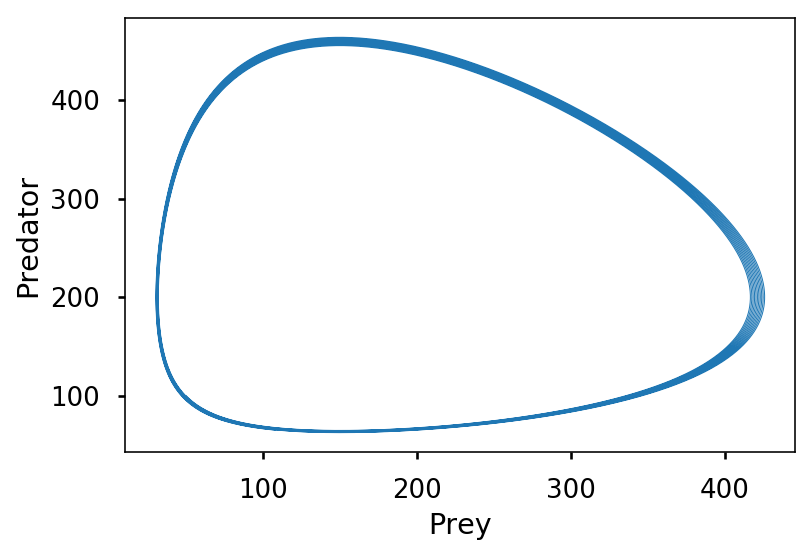

In [6]:
plt.plot(x, y, lw=0.5)
plt.xlabel('Prey')
plt.ylabel('Predator');

We are better off using one of SciPy's [solve_ivp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html), which automatically choses `dt` and `steps` to make sure `dx` and `dy` are small so that the linearization is effective.

Some of the solvers require the Jacobian - the 2nd order parital derivatives.

In [7]:
def jac(t, xy, b, h, ϵ, d):
    x, y = xy
    return [
        [b - h * y, -h * x],
        [ϵ * h * y, ϵ * h * x - d]
    ]

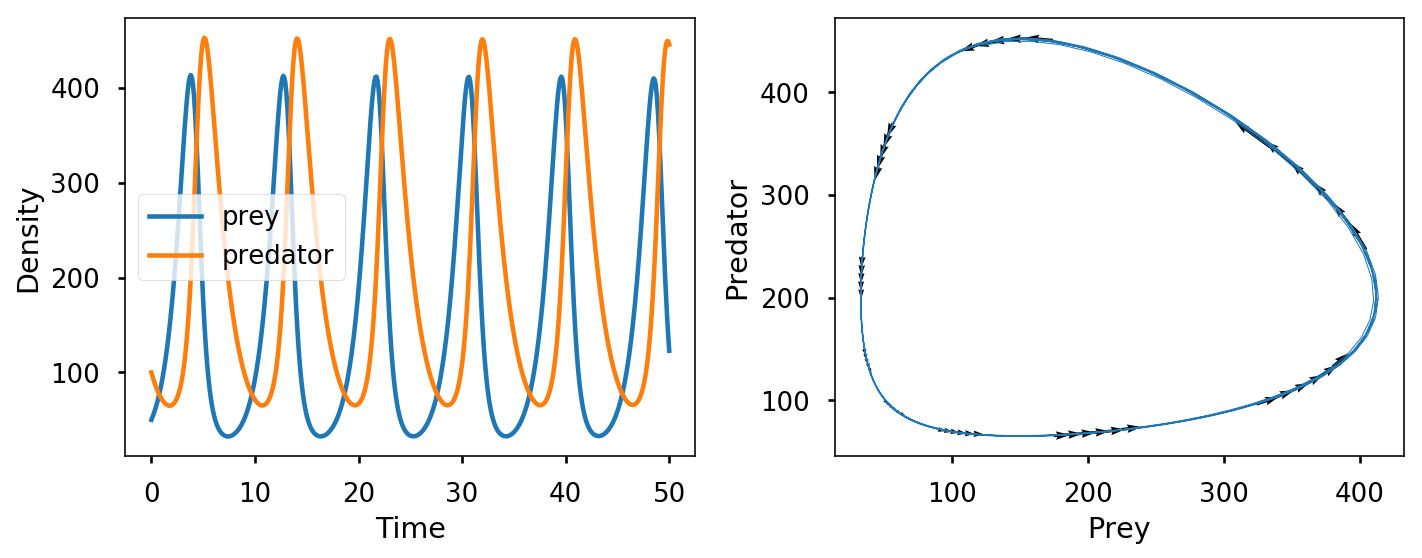

In [9]:
def solve_plot(x0, y0, tmax, b, h, ϵ, d):
    t = np.linspace(0, tmax, tmax*10)
    xy0 = (x0, y0)
    _dxydt = partial(dxydt, b=b, h=h, ϵ=ϵ, d=d)
    _jac = partial(jac, b=b, h=h, ϵ=ϵ, d=d)
    sol = solve_ivp(_dxydt, (t.min(), t.max()), xy0, t_eval=t, method='BDF', jac=_jac)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    ax = axes[0]
    ax.plot(sol.t, sol.y.T)
    ax.legend(('prey', 'predator'))
    ax.set(xlabel='Time', ylabel='Density')

    ax = axes[1]
    ax.plot(sol.y[0,:], sol.y[1,:], lw=0.5)
    ax.quiver(sol.y[0,:-1:10], sol.y[1,:-1:10], sol.y[0,1::10]-sol.y[0,:-1:10], sol.y[1,1::10]-sol.y[1,:-1:10], 
               scale_units='xy', angles='xy', scale=1, width=0.005)

    ax.set(xlabel='Prey', ylabel='Predator')

    fig.tight_layout()
    return sol.t, sol.y

solve_plot(50, 100, 50, b, h, ϵ, d);

We immediately see that we have a cycle, which seems stable!

**Note** this is an example where the `method` of the ODE solver is important - change the method and you don't get a cycle due to numerical errors.

We can explore the dynamics for different values using `interact` - try to check if the cycle is stable for other choice of parameters.

In [11]:
interact(solve_plot,
          x0=(1, 100, 1), y0=(1, 100, 1), tmax=(1, 1001, 10), 
          b=(0, 2, 0.1), h=(0, 0.1, 0.001), ϵ=(0, 1, 0.1), d=(0, 2, 0.1));

interactive(children=(IntSlider(value=50, description='x0', min=1), IntSlider(value=50, description='y0', min=…

# Equilibrium

Population equilibrium occurs in the model when neither of the population levels is changing, i.e. when both of the derivatives are equal to 0:

$$
bx - hxy = 0 \\
\epsilon h x y - d y = 0 \Rightarrow \\
x (b - hy) = 0 \\
y (\epsilon h x - d) = 0
$$

The trivial solutions have $x=0$ and/or $y=0$.
Assuming both are positive,

$$
x^* = \frac{d}{\epsilon h} \\
y^* = \frac{b}{h}
$$

Equilibrium predator density $y^*$ is defined by the ratio of prey birth rate and predation rate.

Equilibrium prey density $x^*$ is defined by the ratio of predator death rate and prey-predator conversion rate.

Clearly, if something causes predator death $d$ it will increase the density of prey, but not the predator, as the increase of prey density will balance the deaths of the predator; if something increases the birth rate of the prey $b$, the prey density will not increase - rather, the predator density will increase as nothing balances it.

Also, the predator equiliubrium is not affected by $\epsilon$ the efficiency of converting predator to prey. The more prey is needed to make a predator (think relative masses of predator and prey) the lower the equilibrium rate of the *prey*.

Perhaps more surprisingly, the more higher the predation rate $h$, we have less of both the predator and the prey - the prey will decreaes, obviously, but the predator will, too.
This will present an interesting "dillema" - a highly skilled predator individual will enjoy the benefit of more prey, but will ultimately cause the predator population to decrease in density, unless balances by increased birth of prey $b$ or increase in prey evasion (which will lower $h$).

In [12]:
xystar = d/(ϵ*h), b/h

dxydt(0, xystar, b=b, h=h, ϵ=ϵ, d=d)

array([0., 0.])

/Users/yoavram/miniconda3/envs/scipy/lib/python3.6/site-packages/scipy/integrate/_ivp/bdf.py:418: RuntimeWarning: divide by zero encountered in power
  factors = error_norms ** (-1 / np.arange(order, order + 3))


(True, True)

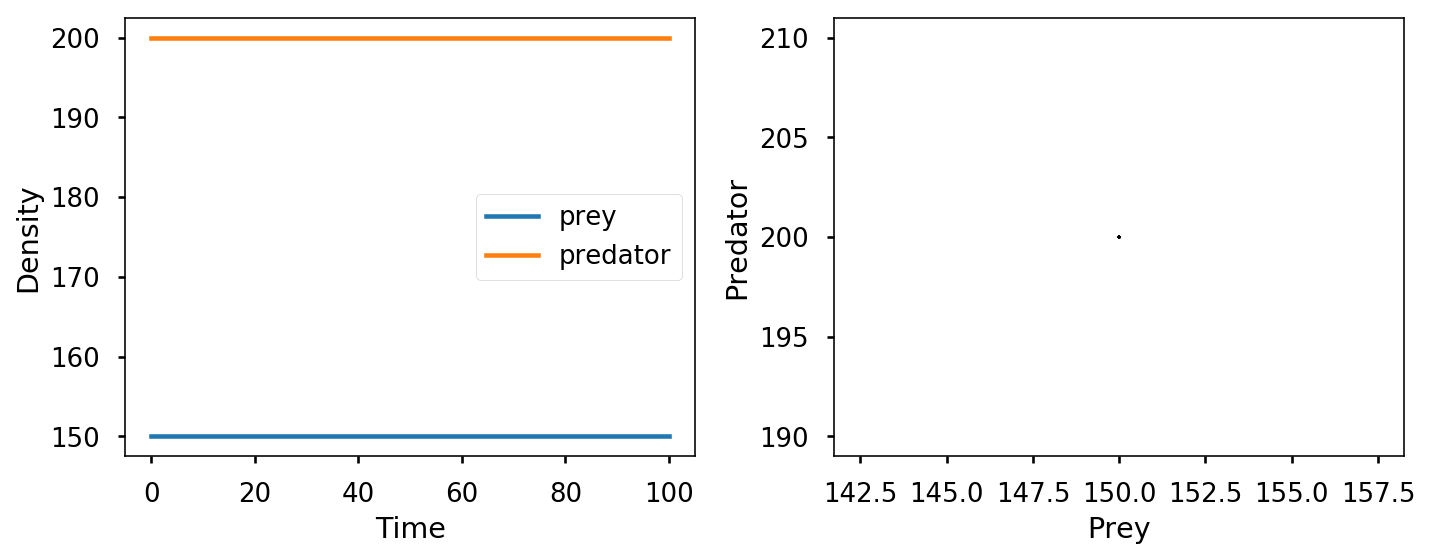

In [13]:
t, xy = solve_plot(x0=d/(ϵ*h), y0=b/h, tmax=100, b=b, h=h, ϵ=ϵ, d=d)
(xy[0,:]==xystar[0]).all(), (xy[1,:]==xystar[1]).all()

# Stability

Is this equilibrium (locally) stable? That is, if we pertrube the system, will it return to the equilibrium?

We concentrate on small pertubrations, that is, the concept of **local stability** (see ch. 8 in Otto and Day 2007).

In [14]:
xypret = xystar[0] * 1.01, xystar[1] * 1.01
dxydt(0, xypret, b=b, h=h, ϵ=ϵ, d=d)

array([-1.515,  1.212])

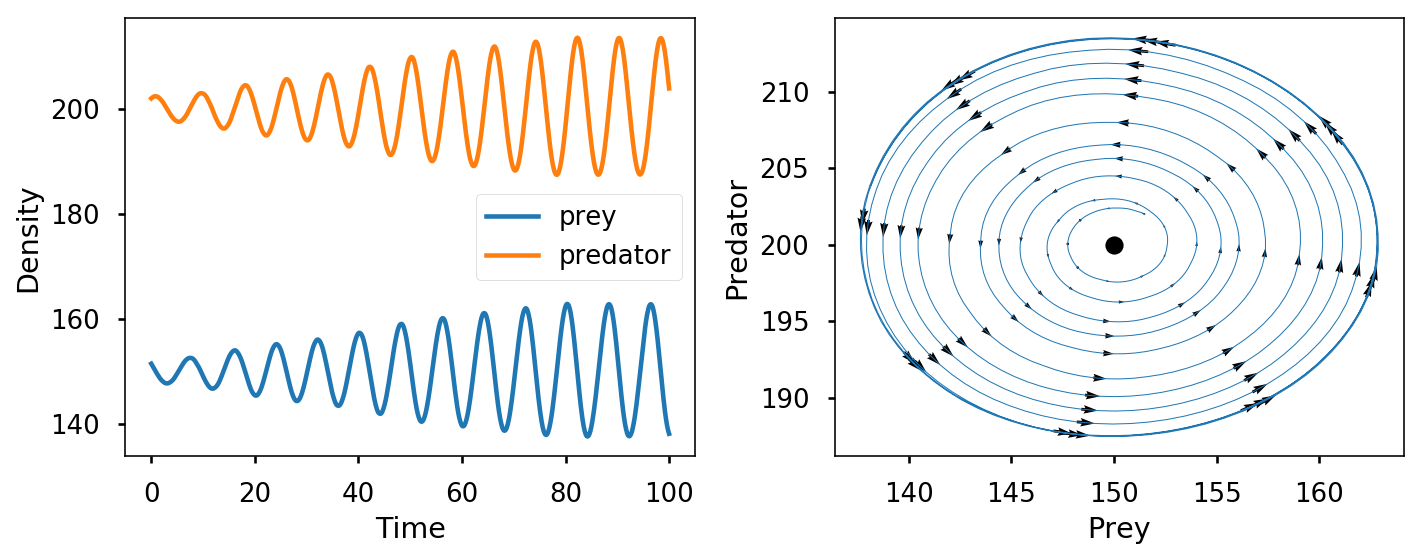

In [15]:
t, xy = solve_plot(*xypret, tmax=100, b=b, h=h, ϵ=ϵ, d=d)
plt.plot(*xystar, 'ok');

The equilibrium point is not stable - it "swirls" outwards, but is seems to "swirl" towards some limit cycle.

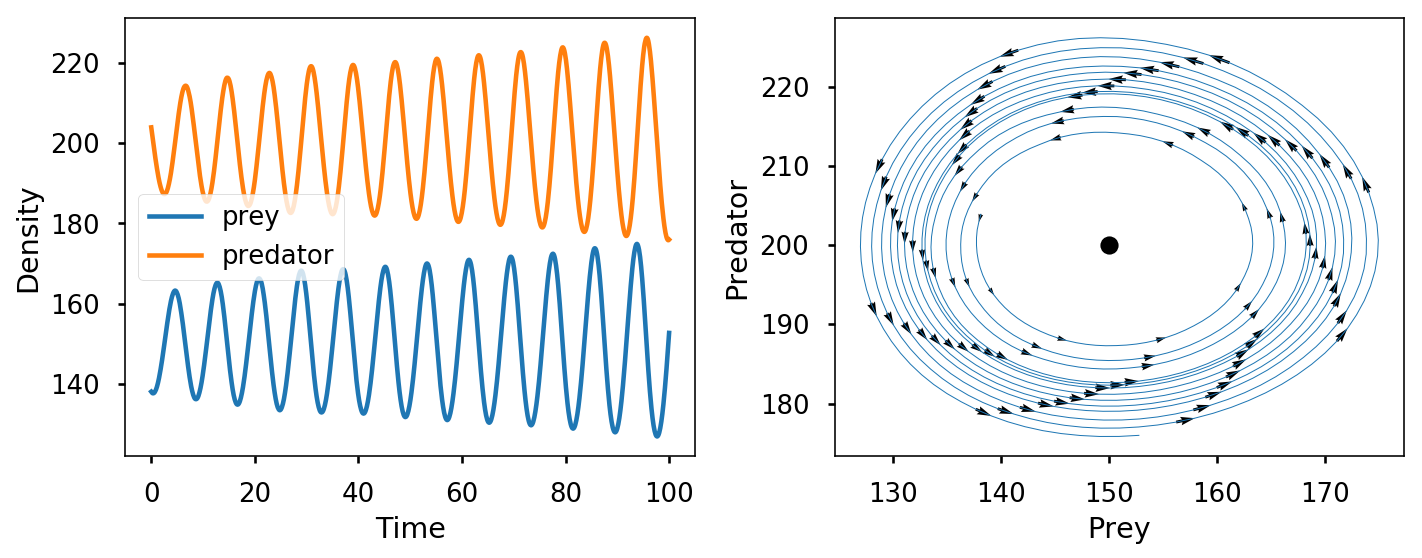

In [16]:
xy0 = xy[:, -1]
solve_plot(*xy0, tmax=100, b=b, h=h, ϵ=ϵ, d=d)
plt.plot(*xystar, 'ok');

We can see that from analysis, too, by deriving the Jacobian (the partial derivatives matrix), evaluating it at the equiblirum $(x^*, y^*)$, and finding the eigenvalues.
The equilibrium is stable if all eigenvalues have negative real parts.

In [17]:
def jacobian(xy, b, h, ϵ, d):
    x, y = xy
    return np.array(
        [
            [b - h * y, - h * x],
            [ϵ * h * y, ϵ * h * x - d]
        ]
    )

In [18]:
xystar = d/(ϵ*h), b/h

J = jacobian(xystar, b, h, ϵ, d)
print(J)

[[ 0.   -0.75]
 [ 0.8   0.  ]]


In [19]:
eigs = np.linalg.eigvals(J)
print('eigenvalues:', eigs.real)
print('real parts are negative:', eigs.real < 0)

eigenvalues: [0. 0.]
real parts are negative: [False False]


In [20]:
def is_stable(b, h, ϵ, d):
    xystar =  d/(ϵ*h), b/h
    J = jacobian(xystar, b, h, ϵ, d)
    eigs = np.linalg.eigvals(J)
    rho = eigs.real.max() 
    return rho < 0 and not np.isclose(rho, 0)

In [21]:
b = 2/3
h = 4/3

ϵs = np.linspace(1e-6, 1, 51)
ds = np.linspace(0, 1, 50)

ρs = [is_stable(b, h, ϵ, d) for ϵ in ϵs for d in ds]
ρs = np.array(ρs).reshape(51, 50)

In [22]:
print('Unstable across range?', not ρs.any())

Unstable across range? True


Can we find an analytic solution for the stability question?

In [23]:
import sympy
sympy.init_printing()

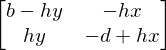

In [24]:
x, y, b, h, ϵ, d = sympy.symbols('x y b h ϵ d')
dxdt = b * x - h * x * y
dydt = ϵ * h * x * y - d * y
J = sympy.Matrix([
    [sympy.diff(dxdt, x), sympy.diff(dxdt, y)],
    [sympy.diff(dydt, x), sympy.diff(dydt, y)]
])
J

First, the case of the trivial equilibrium $x=0, y=0$:

In [25]:
J.subs({x:0, y:0}).eigenvals()

The first eigenvalue is equal to $b>0$, so extinctions are not stalbe to perubations.

Second, the more interesting case: 

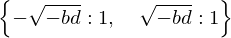

In [26]:
J.subs({x:d/(ϵ*h), y:b/h}).eigenvals()

Now since $bd>0$ both eigenvalues are complex with a zero real part and therefore there is a stable cycle (orbit) around the fixed point.

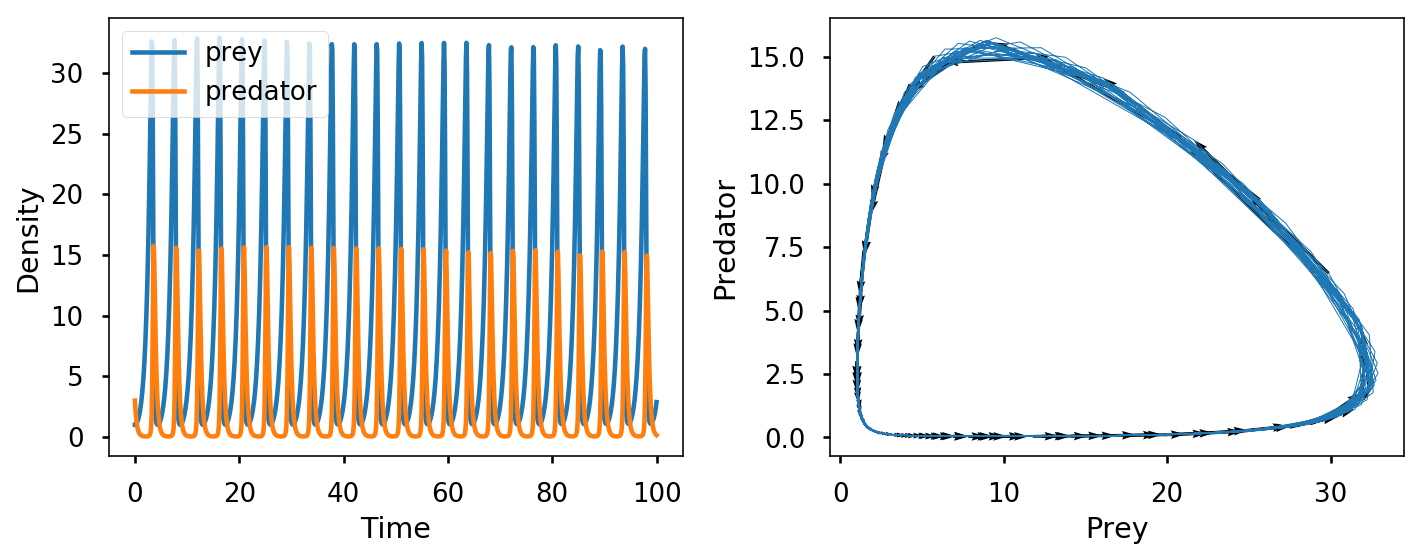

In [27]:
t, xy = solve_plot(1, 3, 100, 1.3, 0.5, 0.7, 3.2);

# Stochastic effects 

The problem is that both prey and predator come very close to zero many times, and therefore their populations will be subject to random extinctions.
If the prey goes extinct, so will the predator:

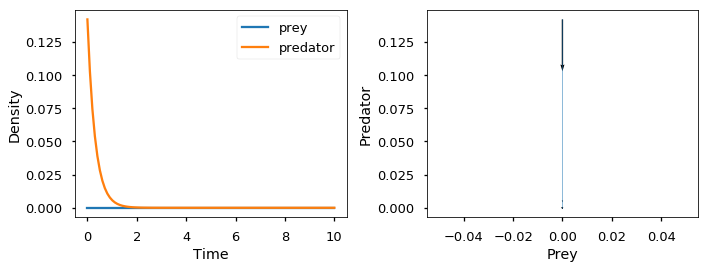

In [229]:
solve_plot(0, xy[1,-1], 10, 1.3, 0.5, 0.7, 3.2);

and if the predator goes extinct, the prey population explodes:

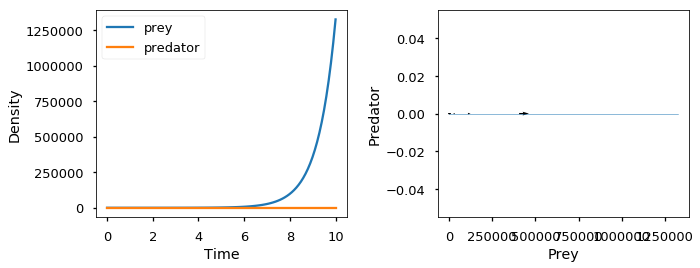

In [230]:
solve_plot(xy[0,-1], 0, 10, 1.3, 0.5, 0.7, 3.2);

So clearly the model is not biologically reasonable - but it can still give us insight on species interactions.

Furthermore, we will come back to this problem and use a stochastic model.

# Further reading

- [Discussion of predation with some biological data](https://globalchange.umich.edu/globalchange1/current/lectures/predation/predation.html)
- [Isle Royale - Wolf and Moose](http://www.isleroyalewolf.org/http%3A//www.cpc.ncep.noaa.gov/products/precip/CWlink/pna/nao.shtml)
- [Evolution towards oscillation or stability in a predator–prey system](http://rspb.royalsocietypublishing.org/content/277/1697/3163)